# Action Space analysis for AWS DeepRacer
This notebook has been built for the [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 
provided by  the [AWS DeepRacer Community](http://join.deepracing.io).

## Usage
Copy this Notebook to "work" folder in your allready installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git)

**This notebook isn't complete.**
If you find some bugs, have problems with some tracks or something else
please report to @Kire in [AWS Machine Learning Community](https://aws-ml-community.slack.com) on #Slack

## Contributions
As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them
to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Requirements
Installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 

## Credits
I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io)

# Log Analysis

Let's get to it.

## Imports

Run the imports block below:

In [1]:
#!docker logs --tail all $(docker ps | awk ' /sagemaker/ { print $1 }') > /home/ubuntu/deepracer/github/deepracer-log-analysis/logs/local-sagemaker_50.log 2>&1
#!docker logs --tail all $(docker ps | awk ' /robomaker/ { print $1 }') > /home/ubuntu/deepracer/github/deepracer-log-analysis/logs/local-robomaker_50.log 2>&1

EPISODES_PER_ITERATION = 20 #  Set to value of your hyperparameter in training
#EPISODES_PER_ITERATION = 40 #  Set to value of your hyperparameter in training


In [2]:
# AWS DeepRacer Console
# stream_name = 'training-20201115184803-ehYPVaEJRxG-V3oc62Te_Q-robomaker' ## CHANGE This to your simulation application ID
fname = 'logs/local-robomaker_50.log'  # The log will be downloaded into the specified path
fname

'logs/local-robomaker_50.log'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from deepracer.tracks import TrackIO, Track
#from deepracer.tracks.track_utils import track_breakdown
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    PlottingUtils as pu,\
    AnalysisUtils as au   #, \
    #   ActionBreakdownUtils as abu,\
    #   NewRewardUtils as nr, \ 

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500, 'display.max_columns', None)

## Load waypoints for the track you want to run analysis on

Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [4]:
tu = TrackIO()

for f in tu.get_tracks():
    print(f)

AWS_track.npy
Albert.npy
AmericasGeneratedInclStart.npy
Aragon.npy
Austin.npy
Belille.npy
Bowtie_track.npy
Canada_Eval.npy
Canada_Training.npy
ChampionshipCup2019_track.npy
China_eval_track.npy
China_track.npy
FS_June2020.npy
H_track.npy
July_2020.npy
LGSWide.npy
London_Loop_Train.npy
Mexico_track.npy
Mexico_track_eval.npy
Monaco.npy
Monaco_building.npy
New_York_Eval_Track.npy
New_York_Track.npy
Oval_track.npy
Singapore.npy
Singapore_building.npy
Singapore_f1.npy
Spain_track.npy
Spain_track_f1.npy
Straight_track.npy
Tokyo_Training_track.npy
Vegas_track.npy
Virtual_May19_Train_track.npy
reInvent2019_track.npy
reInvent2019_wide.npy
reInvent2019_wide_mirrored.npy
reinvent_base.npy


Take the name from results above and paste below to load the key elements of the track and view the outline of it.

Loaded 235 waypoints


<AxesSubplot:>

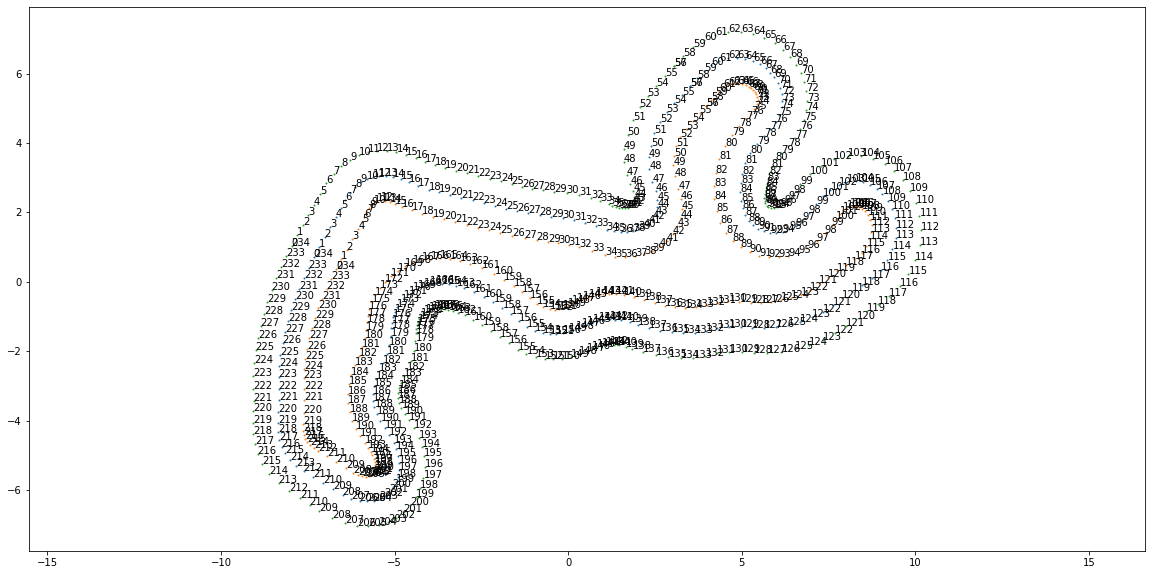

In [5]:
track: Track = tu.load_track("Monaco")
 
l_track = track.center_line
l_outer_border = track.outer_border
l_inner_border = track.inner_border

pu.plot_trackpoints(track)

## Get the logs

Depending on which way you are training your model, you will need a different way to load the data.

**AWS DeepRacer Console**
The logs are being stored in CloudWatch, in group `/aws/robomaker/SimulationJobs`. You will be using boto3 to download them based on the training ID (stream name prefix). If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3 :: https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html

**DeepRacer for Dummies/ARCC local training**
Those two setups come with a container that runs Jupyter Notebook (as you noticed if you're using one of them and reading this text). Logs are stored in `/logs/` and you just need to point at the latest file to see the current training. The logs are split for long running training if they exceed 500 MB. The log loading method has been extended to support that.

**Chris Rhodes' repo**
Chris repo doesn't come with logs storage out of the box. I would normally run `docker logs dr > /path/to/logfile` and then load the file.

Below I have prepared a section for each case. In each case you can analyse the logs as the training is being run, just in case of the Console you may need to force downloading of the logs as the `cw.download_log` method has a protection against needless downloads.

Select your preferred way to get the logs below and you can get rid of the rest.

In [6]:
# AWS DeepRacer Console
#stream_name = 'sim-test' ## CHANGE This to your simulation application ID
#fname = 'logs/%s.log' %stream_name  # The log will be downloaded into the specified path
#cw.download_log(fname, stream_prefix=stream_name)  # add force=True if you downloaded the file before but want to repeat


# DeepRacer for Dummies / ARCC repository - comment the above and uncomment
# the lines below. They rely on a magic command to list log files
# ordered by time and pick up the most recent one (index zero).
# If you want an earlier file, change 0 to larger value.
# !ls -t /workspace/venv/logs/*.log
# fname = !ls -t /workspace/venv/logs/*.log
# fname = fname[0]


# Chris Rhodes' repository
# Use a preferred way of saving the logs to a file , then set an fname value to load it
# fname = /path/to/your/log/file

## Load the trace training log

Now that the data is downloaded, we need to load it into memory. We will first read it from file and then convert to data frames in Pandas. [Pandas](https://pandas.pydata.org/) is a Python library for handling and analysing large amounts of data series. Remember this name, you may want to learn more about how to use it to get more information that you would like to get from the logs. Examples below are hardly scratching the surface.

One important information to enter is the setting of your Episodes per iteration hyperparameter. This is used to group the episodes into iterations. This information is valuable when later looking at graphs showing how the training progresses per iteration. You can use it to detect which iteration gave you better outcomes and, if in local training, you could move to that iteration's outcome for submissions in the AWS DeepRacer League or  for continuing the training.

The log files you have just gathered above have lines like this one:
```
SIM_TRACE_LOG:799,111,1.7594,4.4353,3.0875,-0.26,2.50,2,1.0000,False,True,71.5802,49,17.67,1555554451.1110387
```
This is all that matters for us. The first two are some tests I believe and when loading they get skipped, then each next line has the following fields:
* episode number
* step number
* x coordinate
* y coordinate
* yaw of the car (where the car is heading)
* decision about turning (turn value from your action space)
* decision about throttle (speed value from your action space)
* decision index (value from your action space)
* reward value
* is the car going backwards
* are all wheels on track?
* progress in the lap
* closest waypoint
* track length
* timestamp

`la.load_data` and then `la.convert_to_pandas` read it and prepare for your usage. Sorting the values may not be needed, but I have experienced under some circumstances that the log lines were not ordered properly.

In [7]:
!ls logs

local-202011180747-robomaker.log
local-202011180747-sagemaker.log
local-202011180957-robomaker.log
local-202011180957-sagemaker.log
local-202011181420-robomaker.log
local-202011181420-sagemaker.log
local-202011181936-robomaker.log
local-202011181936-sagemaker.log
local-202011190453-robomaker.log
local-202011190453-sagemaker.log
local-202011191339-robomaker.log
local-202011191339-sagemaker.log
local-202011191801-robomaker.log
local-202011191801-sagemaker.log
local-202011192058-robomaker.log
local-202011192058-sagemaker.log
local-202011200448-robomaker.log
local-202011200448-sagemaker.log
local-202011200504-robomaker.log
local-202011200504-sagemaker.log
local-202011201523-robomaker.log
local-202011201523-sagemaker.log
local-202011201935-robomaker.log
local-202011201935-sagemaker.log
local-202011210443-robomaker.log
local-202011210443-sagemaker.log
local-202011211318-robomaker.log
local-202011211318-sagemaker.log
local-202011212137-robomaker.log
local-202011212137-sagemaker.log
local-2020

In [8]:
#fname = 'logs/local-202011301951-robomaker.log'

In [9]:

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])
# personally I think normalizing can mask too high rewards so I am commenting it out,
# but you might want it.
# slio.normalize_rewards(df)

#Uncomment the line of code below to evaluate a different reward function
#nr.new_reward(df, l_center_line, 'reward.reward_sample') #, verbose=True)

In [10]:
df['throttle'].mean()

3.3877217494720626

In [11]:
df[['iteration', 'steer', 'throttle']].groupby("iteration").mean()

steer  throttle
iteration                    
1         -2.409470  3.786742
2         -0.951927  3.925558
3         -0.861263  3.782423
4         -0.932584  3.880899
5         -0.890200  3.618486
6         -2.238889  3.731276
7         -2.411978  3.612160
8         -0.896881  3.941996
9         -0.578810  3.780112
10        -0.946384  3.826984
11        -0.749900  3.693214
12        -1.172712  3.777038
13        -2.626655  3.777526
14        -2.312107  3.774214
15        -2.072816  4.081165
16        -2.439474  3.830757
17        -2.485536  3.377143
18        -3.672165  3.792990
19        -2.704665  3.443408
20        -1.748606  3.638153
21        -1.859687  3.410313
22        -2.187605  3.700335
23        -3.163411  3.551656
24        -1.856239  3.301230
25        -1.399484  3.324957
26        -2.760894  3.500000
27        -2.374711  3.330248
28        -2.037849  3.672311
29        -2.763636  3.479895
30        -2.952542  3.664915
31        -1.758240  3.587828
32        -2.661818  3.716162
33        -1.696339  3.702312
34        -1.156703  3.600906
35        -1.137718  3.727892
36        -2.711340  3.375430
37        -2.396774  3.244032
38        -1.212541  3.275908
39        -1.982432  3.520946
40        -1.661672  3.256309
41        -1.477815  3.546891
42        -2.209862  3.518858
43        -2.413849  3.442266
44        -1.804727  3.237273
45        -1.047876  3.434749
46        -1.529238  3.199533
47        -1.174960  3.258748
48        -0.949317  3.364505
49        -1.252902  3.254395
50        -0.952021  3.180316
51        -2.480980  3.291765
52        -1.313093  3.254839
53        -1.573667  3.375121
54        -1.157026  3.320570
55        -1.018738  3.466605
56        -0.762415  3.381803
57        -1.463699  3.231336
58        -1.006344  3.396327
59        -3.071454  3.346631
60        -1.569295  3.191275
61        -1.226843  3.407372
62        -1.703696  3.276848
63        -3.613385  3.277846
64        -2.690015  3.232678
65        -2.631716  3.197920
66        -1.917957  3.173839
67        -3.012701  3.148658
68        -3.525420  3.143697
69        -3.100973  3.195720
70        -2.531765  3.170924
71        -3.102216  3.241507
72        -1.983424  3.212750
73        -1.455814  3.376890
74        -1.780944  3.216515
75        -1.637205  3.132492
76        -3.021857  3.182398
77        -3.542339  3.306260
78        -4.264865  3.276216
79        -1.435253  3.319372
80        -2.553739  3.267652
81        -1.087411  3.450000
82        -1.554790  3.304042
83        -0.672020  3.331788
84        -0.881569  3.560196
85        -0.896402  3.295076
86        -1.927322  3.101457
87        -1.332544  3.460947
88        -0.923009  3.369912
89        -0.197893  3.265326
90        -1.839108  3.489194
91        -1.243019  3.503962
92        -0.782975  3.458423
93        -0.211623  3.264128
94        -2.224278  3.195925
95        -0.415728  3.470199
96        -1.210642  3.338716
97        -1.342966  3.457187
98        -1.596965  3.538449
99        -1.849115  3.315339
100       -3.172128  3.350471
101       -1.441252  3.349438
102       -1.648750  3.355972
103       -1.302264  3.523962
104       -0.809815  3.515556
105        0.270719  3.373116
106       -1.301681  3.373249
107       -1.085940  3.332513
108       -1.805104  3.382420
109       -2.925371  3.216474
110       -0.432953  3.231158
111       -0.480122  3.293119
112       -1.690806  3.173126
113       -0.704392  3.227365
114       -1.630571  3.445120
115       -1.496724  3.133276
116       -1.675603  3.279625
117       -1.840351  3.304386
118       -2.656385  3.305970
119       -2.355473  3.314471
120       -1.569494  3.446166
121       -2.134167  3.228500
122       -1.030972  3.308402
123       -2.394825  3.253425
124       -2.130236  3.198425
125       -2.863730  3.374156
126       -1.864312  3.419384
127       -2.499669  3.490066
128       -1.900185  3.338889
129       -3.227987  3.234119
130       -1.533625  3.201401
131       -2.618505  3.395140
132       -2.648018  3.2

new reward not found, using reward as its values
Number of episodes =  4525
Number of iterations =  227


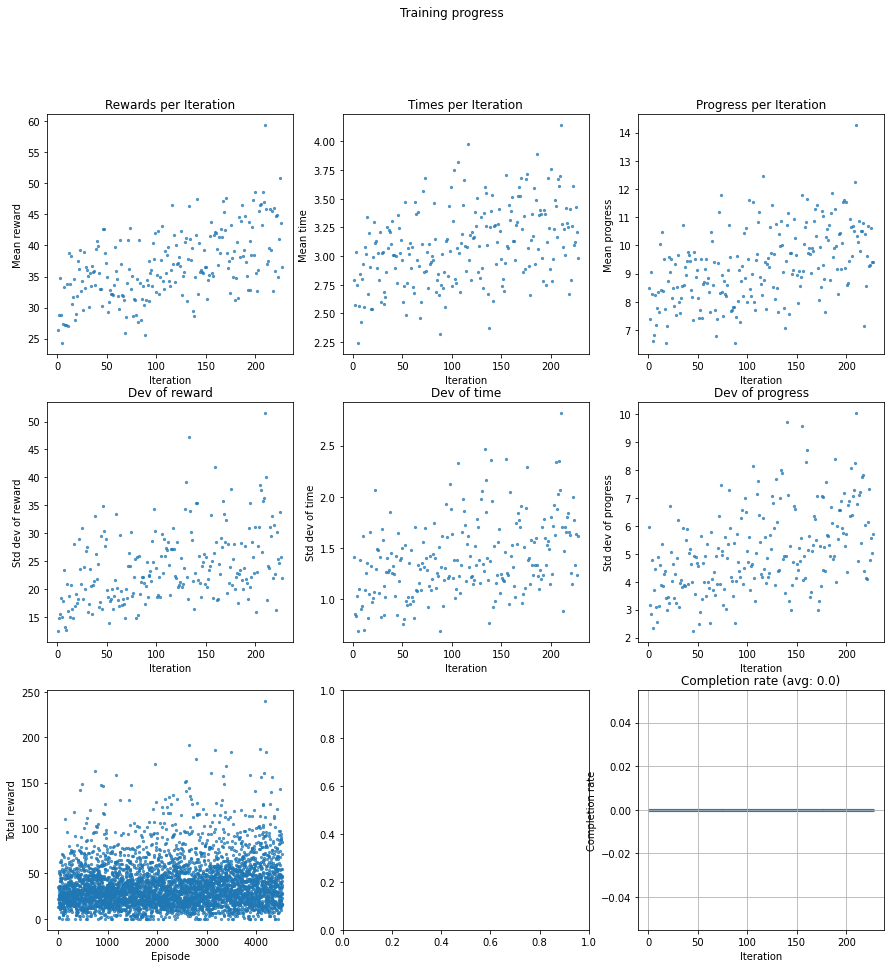

<Figure size 432x288 with 0 Axes>

In [12]:
simulation_agg = au.simulation_agg(df)
au.analyze_training_progress(simulation_agg, title='Training progress')

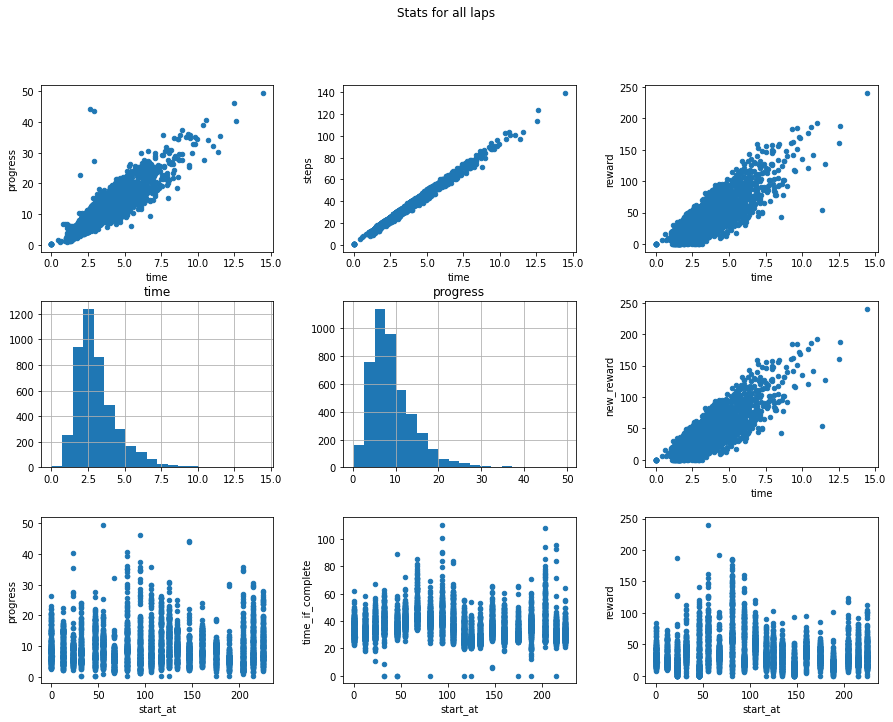

<Figure size 432x288 with 0 Axes>

In [13]:
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

In [14]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

No complete laps yet.


In [15]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(50, 'reward')

Empty DataFrame
Columns: [iteration, episode, steps, start_at, progress, time, new_reward, throttle, reward, time_if_complete, reward_if_complete, quintile, complete]
Index: []

In [16]:
# View five most progressed episodes
simulation_agg.nlargest(5, 'progress')

iteration  episode  steps  start_at  progress       time  new_reward  \
4185        210     4185    139        55   49.4958  14.450618    239.9598   
3088        155     3088    113        94   46.2601  12.511668    160.8718   
3193        160     3193     27       147   44.1460   2.621040     15.8602   
3773        189     3773     28       147   43.7734   2.907839     17.3919   
3167        159     3167    103        81   40.7494  10.588053    185.8146   

      throttle    reward  time_if_complete  reward_if_complete quintile  \
4185  2.956835  239.9598         29.195645          484.808408      5th   
3088  2.944248  160.8718         27.046349          347.754977      4th   
3193  4.300000   15.8602          5.937209           35.926698      4th   
3773  3.721429   17.3919          6.642936           39.731664      5th   
3167  3.183495  185.8146         25.983334          455.993462      4th   

      complete  
4185         0  
3088         0  
3193         0  
3773         0  
3167         0

In [17]:
# View information for a couple last episodes
simulation_agg.tail()

iteration  episode  steps  start_at  progress      time  new_reward  \
4521        227     4521     50        12   17.3878  5.397644     71.0919   
4522        227     4522     20        23    5.3197  2.089390     16.8388   
4523        227     4523     33        32   11.7593  3.428285     47.0245   
4524        227     4524     35        46   11.8920  3.666112     22.4866   
4525        227     4525      7        55    0.9551  0.602611     15.3893   

      throttle   reward  time_if_complete  reward_if_complete quintile  \
4521  4.060000  71.0919         31.042710          408.860810      5th   
4522  4.545000  16.8388         39.276469          316.536647      5th   
4523  3.166667  47.0245         29.153823          399.892000      5th   
4524  3.557143  22.4866         30.828389          189.090145      5th   
4525  2.185714  15.3893         63.094053         1611.276306      5th   

      complete  
4521         0  
4522         0  
4523         0  
4524         0  
4525         0

In [18]:
# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option('display.max_rows', 500)

# View all steps data for episode 10
df[df['episode']==5520]

Empty DataFrame
Columns: [iteration, episode, steps, x, y, yaw, steer, throttle, action, reward, done, on_track, progress, closest_waypoint, track_len, timestamp, new_reward]
Index: []

# Extract Action Space List from LOG file

In [19]:
# Extract Action Space List
dgr_norm = 1 # for degrees

if df['steer'].max()<2: dgr_norm = 57.6923 # for radians

class act(object):
    def __init__(self, index=None, steer=None, throttle=None, rel_thr=None, color=([0,0,0])):
        self.index = index
        self.steer = steer
        self.throttle = throttle # relative throttle, max = 1
        self.rel_thr = rel_thr
        self.color = color

maxThrottle = df.throttle.max()

AS = df[df['steps'] != 0].groupby(['action'], as_index=False)['steer','throttle'].median()
asl = [None] * AS.shape[0]
for i in range(0,AS.shape[0]):
    j = AS.action[i].astype(int)
    #asl[AS.action[i].astype(int)] = [AS.action[i].astype(int), round(AS.steer[i]*dgr_norm,2), round(AS.throttle[i],2)]
    asl[j] = act(j, round(AS.steer[i]*dgr_norm,2), round(AS.throttle[i],2))
    asl[j].rel_thr = AS.throttle[i] / maxThrottle
    
    cr = 8*max(0,np.sign(asl[j].steer))*abs(asl[j].steer)/255
    cg = (0+6*(30-abs(asl[j].steer)))/255
    cb = -8*min(0,np.sign(asl[j].steer))*abs(asl[j].steer)/255
 
    asl[AS.action[i].astype(int)].color = ([cr,cg,cb])

asMaxY = maxThrottle + 1

#########################################################
# define some constants for track graphs
trkFrame = 50

trkPlotXmin = df.x.min() - trkFrame
trkPlotXmax = df.x.max() + trkFrame
trkPlotYmin = df.y.min() - trkFrame
trkPlotYmax = df.y.max() + trkFrame

trkPlotXmin = min(l_outer_border[:,0]) - trkFrame
trkPlotXmax = max(l_outer_border[:,0]) + trkFrame
trkPlotYmin = min(l_outer_border[:,1]) - trkFrame
trkPlotYmax = max(l_outer_border[:,1]) + trkFrame

trkSizeX = int(trkPlotXmax - trkPlotXmin)
trkSizeY = int(trkPlotYmax - trkPlotYmin)

trkShiftX = int(trkSizeX - trkPlotXmax)
trkShiftY = int(trkSizeY - trkPlotYmax)

#print(trkSizeX,trkSizeY,trkPlotYmin,trkPlotYmax)

##########################################################
# define some constants for Action Space graphs

asPlotXmin = round(df.steer.min()*dgr_norm,2)
asPlotXmax = round(df.steer.max()*dgr_norm,2)
asPlotYmin = round(df.throttle.min(),2)
asPlotYmax = round(df.throttle.max(),2)

#df.throttle.min()
#print(asPlotXmin,asPlotXmax,asPlotYmin,asPlotYmax)

###############################################################

print("Actions: \nindex\t\tsteering\tthrottle")
for obj in asl: 
    print( obj.index, obj.steer, obj.throttle, sep ='\t\t' ) 
    

Actions: 
index		steering	throttle
0		-30.0		1.2
1		-23.0		1.4
2		-18.9		1.6
3		-12.1		2.5
4		-8.0		3.5
5		-6.0		5.0
6		-3.4		5.0
7		-2.7		2.5
8		-0.5		4.9
9		-0.3		7.0
10		0.0		8.0
11		0.9		7.0
12		3.6		2.6
13		6.4		4.0
14		7.7		3.5
15		8.5		1.5
16		12.0		3.7
17		15.2		2.4
18		19.0		1.5
19		23.0		1.4
20		30.0		1.2


## Function definitions

In [20]:
## Action Index Map
def plot_index_map(actSpaceList):
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot(111)
    for obj in actSpaceList:
        N=100
        ax.set_title('Action Index Map')
        ax.axis([-35, 35, 0, asMaxY])
        ax.set(xlabel='Steering', ylabel='Speed',  xlim=(35,-35))
        scatter = ax.scatter((0.0 + obj.steer), (0.0 + obj.throttle),
                     color = obj.color,
                     s=1200 * obj.rel_thr,
                     alpha=0.85)
        ax.text((0.5 - obj.steer/70), (0.0 + obj.throttle/asMaxY), 
                obj.index,verticalalignment='center',
                horizontalalignment='center',
                transform=ax.transAxes, color ="w",
                fontsize=15)
    plt.show()

### Action space histograms

# 4 in 1 Histograms
def plot_4_hist(df, itr=-1,  E=-1):
    if itr > -1 :
        episode_data = df[df['iteration'] == itr]
        print('Histograms for iteration:',itr)
    else:
        if E > -1 :
            episode_data = df[df['episode'] == E]
            print('Histograms for episode:',E)
        else:
            episode_data = df[:]
            print('Histograms for all episodes:') 
    fig, axs = plt.subplots(2, 2, sharex='col',figsize=(14, 10), sharey='row',  gridspec_kw={'hspace': 0, 'wspace': 0})  
    (ax1, ax2), (ax3, ax4) = axs
    ax3.hist2d(episode_data['steer']*(dgr_norm), episode_data['throttle'], bins=(63, 56),range=[[-31,31],[0,asMaxY]])
    ax3.set(xlabel='Steering', ylabel='Speed',  xlim=(31,-31)) 
    ax2 = plt.subplot(222, polar=True)
    ax2.set_theta_zero_location("N")
    ax2.hist2d(episode_data['steer']*(dgr_norm/57.6923), episode_data['throttle'], bins=(90, 23),range=[[-1.57,1.57],[0,asMaxY]])
        # ax2.hist(episode_data['action']*dgr_norm, bins=60)
    ax1.hist(episode_data['steer']*dgr_norm, bins=60)
    ax4.hist(episode_data['throttle'], bins=50, orientation="horizontal")# steer - throttle - actions
    for ax in fig.get_axes():
        ax.label_outer()
        
## Big Polar 2D Histogram
def plot_polar_hist(df, itr=-1,  E=-1):
    if itr > -1 :
        episode_data = df[df['iteration'] == itr]
        print('Histograms for iteration:',itr)
    else:
        if E > -1 :
            episode_data = df[df['episode'] == E]
            print('Histograms for episode:',E)
        else:
            episode_data = df[:]
            print('Histogram for all episodes:')           
    fig2 = plt.figure(1, figsize=(7, 7))    
    bx = fig2.add_subplot(111, polar=True)
    bx.set_theta_zero_location("N")
    bx.hist2d(episode_data['steer']*(dgr_norm/57.6923), episode_data['throttle'], bins=(90, 25),range=[[-1.57,1.57],[0,asMaxY]])
       
## Ploting steps in the episodes with red dots
def plot_episode_red(df, E): #, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX/5, trkSizeY/5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke") # center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')        
        
## Ploting steps in the episodes with dots of different colors and sizes
def plot_episode_color(df, E): #, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX/5, trkSizeY/5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke") # center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        actidx = int(action)
        action_color = asl[int(action)].color
        action_s = (asl[int(action)].throttle / maxThrottle)**2 * 50 # tune the size of the dots
        #print(action_color)
        #plt.scatter([x1, car_x2], [y1, car_y2], color=action_color, s=action_s, alpha=0.65)
        plt.scatter(x1, y1, color=action_color, s=action_s, alpha=0.75)

# Action Space Visualization

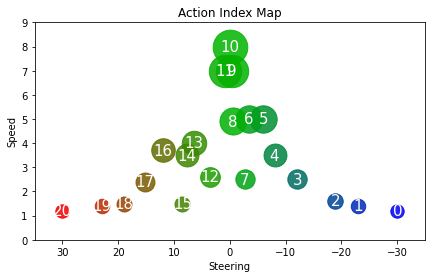

In [21]:
plot_index_map(asl)    

# Analysing data from all episodes

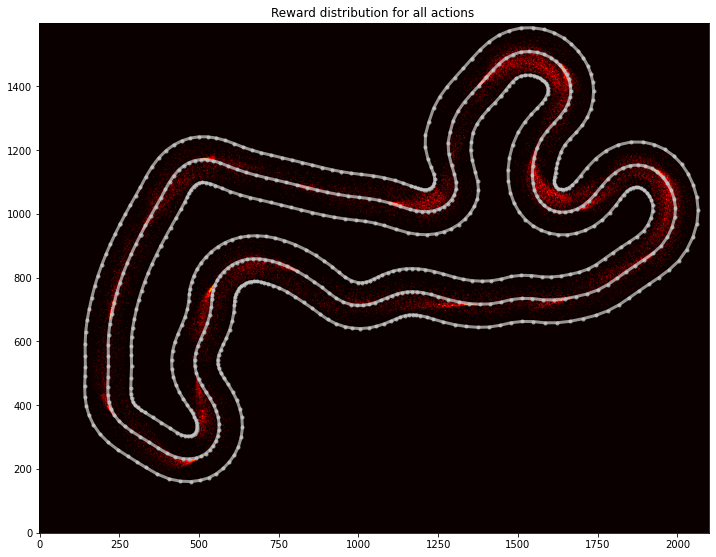

<Figure size 432x288 with 0 Axes>

In [22]:
tr_plot = pu.plot_track(df, track, value_field="reward") 

Histograms for all episodes:


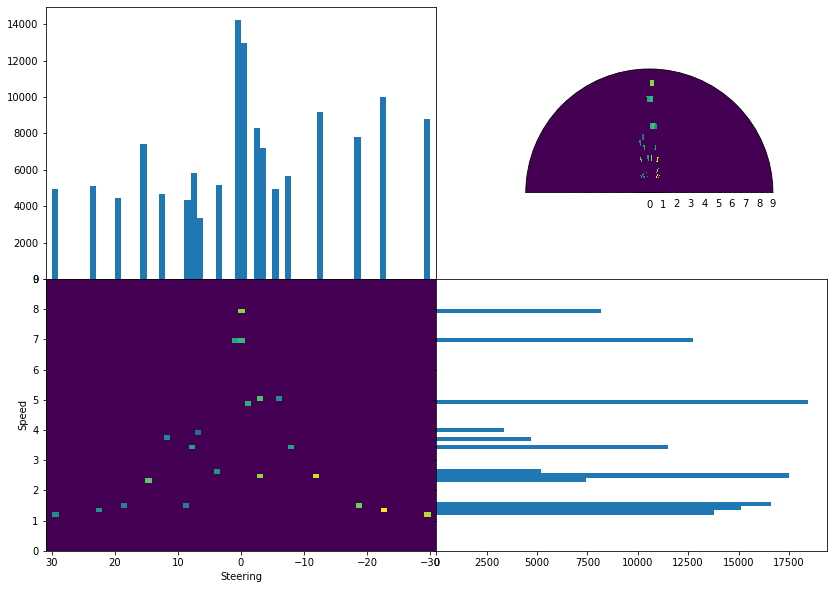

In [23]:
plot_4_hist(df)

Histogram for all episodes:


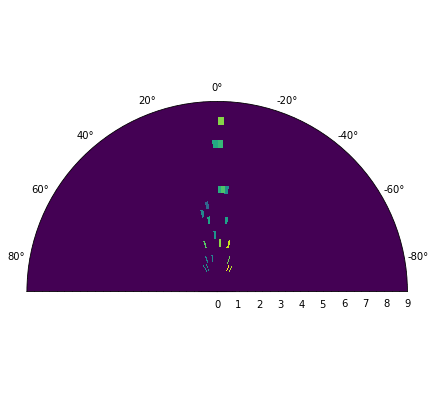

In [24]:
plot_polar_hist(df)



# Analyzing specific iteration





In [25]:
# Set iteration id
#itr = 12                      # iteration id
itr=df['iteration'].max()-1     # last iteration

In [26]:
df

iteration  episode  steps       x       y      yaw  steer  throttle  \
0               1        0      3 -7.2503  0.8577  62.4256    7.7       3.5   
1               1        0      4 -7.2180  0.9310  63.5221    7.7       3.5   
2               1        0      5 -7.1834  1.0202  65.5587  -18.9       1.6   
3               1        0      6 -7.1392  1.1361  67.3039  -18.9       1.6   
4               1        0      7 -7.0581  1.2995  64.9922   -2.7       2.5   
...           ...      ...    ...     ...     ...      ...    ...       ...   
134550        227     4525      3  3.2835  5.3893  48.1296   15.2       2.4   
134551        227     4525      4  3.3173  5.4372  49.6549  -12.1       2.5   
134552        227     4525      5  3.3676  5.5117  51.7612  -18.9       1.6   
134553        227     4525      6  3.4203  5.5778  51.5913  -12.1       2.5   
134554        227     4525      7  3.5162  5.6846  49.8268  -12.1       2.5   

        action  reward  done on_track  progress  closest_waypoint  track_len  \
0         14.0  3.3236     0     True    0.2823                 1      60.27   
1         14.0  3.3149     0     True    0.4148                 1      60.27   
2          2.0  0.0010     0     True    0.5721                 1      60.27   
3          2.0  0.0010     0     True    0.7759                 1      60.27   
4          7.0  0.0010     0     True    1.0783                 2      60.27   
...        ...     ...   ...      ...       ...               ...        ...   
134550    17.0  3.3202     0     True    0.3322                55      60.27   
134551     3.0  3.1272     0     True    0.4290                55      60.27   
134552     2.0  0.0010     0     True    0.5767                55      60.27   
134553     3.0  3.1042     0     True    0.7167                56      60.27   
134554     3.0  2.5121     0     True    0.9551                57      60.27   

                 timestamp  new_reward  
0        1606827238.483345      3.3236  
1        1606827238.587408      3.3149  
2         1606827238.70353      0.0010  
3        1606827238.820607      0.0010  
4       1606827238.9297078      0.0010  
...                    ...         ...  
134550  1606850415.1121166      3.3202  
134551  1606850415.1990595      3.1272  
134552  1606850415.2530951      0.0010  
134553  1606850415.3890944      3.1042  
134554  1606850415.4996104      2.5121  

[134555 rows x 17 columns]

Iteration: 226


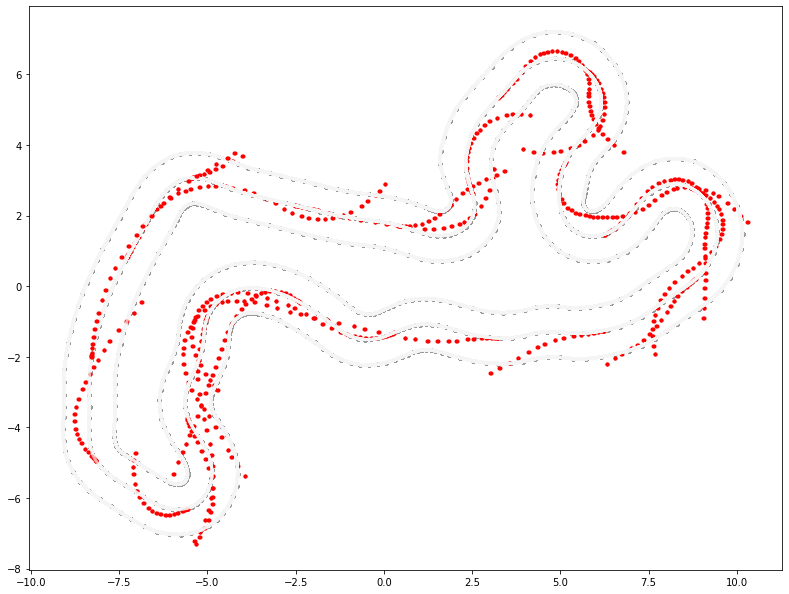

In [27]:
for i in range((itr-1)*EPISODES_PER_ITERATION, (itr)*EPISODES_PER_ITERATION):
    plot_episode_red(df,i) #,l_inner_border, l_inner_border, l_outer_border)
print('Iteration:',itr)    

Histograms for iteration: 226


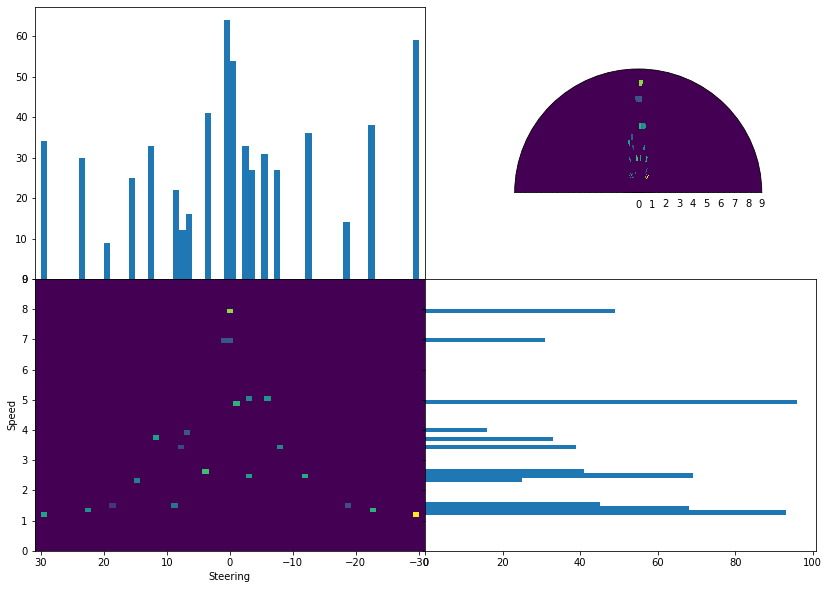

In [28]:
#plot_episode_as_hist(df, itr=25)  # specific iteration
plot_4_hist(df, itr)  # last iteration

Histograms for iteration: 226


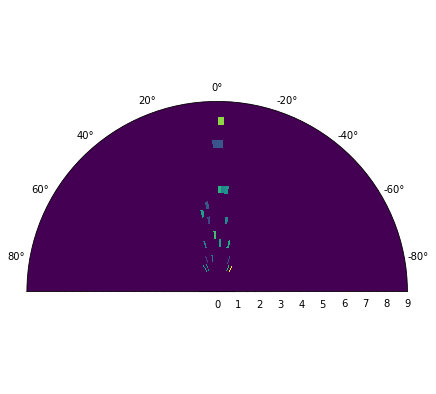

In [29]:
plot_polar_hist(df, itr)



# Analyzing specific episode



In [30]:
### choose episode id
#EPZ = 15
EPZ = df['episode'].max()
ITZ = df['iteration'].max()-1
#EPZ = 60
#EPZ = 442

<AxesSubplot:>

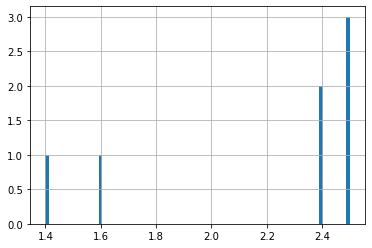

In [31]:
df[df['episode']==EPZ]['throttle'].hist(bins=80)

<AxesSubplot:>

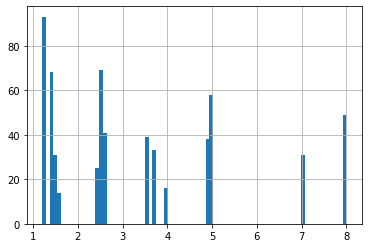

In [32]:
df[df['iteration']==ITZ]['throttle'].hist(bins=80)

<AxesSubplot:>

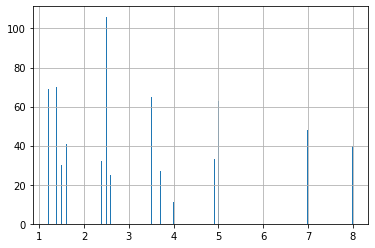

In [33]:
df[df['iteration']==140]['throttle'].hist(bins=300)

<AxesSubplot:>

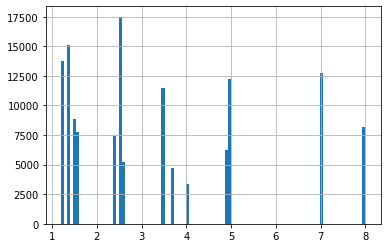

In [34]:
df['throttle'].hist(bins=100)

<AxesSubplot:>

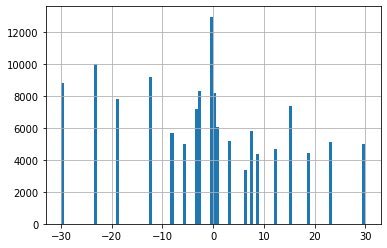

In [35]:
df['steer'].hist(bins=100)

In [36]:
df['throttle'].mean()

3.3877217494720626

In [37]:
df.groupby("iteration").mean()

episode      steps         x         y        yaw     steer  \
iteration                                                                    
1            10.592803  16.365530 -0.233638  0.551587  -3.957656 -2.409470   
2            29.823529  13.884381 -0.502241  0.419458 -23.789357 -0.951927   
3            49.658703  16.186007 -0.155384  0.529459 -16.247294 -0.861263   
4            69.588015  15.443820  0.069994  0.640757   2.212985 -0.932584   
5            88.933185  12.608018  0.419269  0.737614 -27.212162 -0.890200   
6           109.080247  14.448560  1.004366  0.705854 -11.487652 -2.238889   
7           128.829401  17.215971  0.723031  1.211912 -18.635750 -2.411978   
8           148.819127  13.968815  0.568589  0.684889 -13.606732 -0.896881   
9           169.314126  15.206320  0.244061  0.622115  -7.739293 -0.578810   
10          188.546737  18.597884  0.888180  1.074337 -12.891335 -0.946384   
11          209.049900  13.836327  0.346966  0.616844 -12.757303 -0.749900   
12          228.534110  17.196339  0.843353  0.695198 -29.511681 -1.172712   
13          248.722997  17.006969  1.294595  0.766716 -18.611523 -2.626655   
14          268.529874  18.737421  1.151385  1.015938  -9.233177 -2.312107   
15          289.361165  14.625243 -0.081219  0.392067  -7.126000 -2.072816   
16          308.957237  17.115132  0.605136  0.640213  -7.253611 -2.439474   
17          328.203571  18.376786  1.678251  1.141475 -21.096962 -2.485536   
18          348.173196  15.560825  0.661699  0.708837 -32.192168 -3.672165   
19          369.245436  14.363083  0.692365  0.607690 -21.332373 -2.704665   
20          389.397213  16.189895  0.239349  0.824155 -16.316344 -1.748606   
21          408.826563  18.012500  0.944893  0.827924 -25.597904 -1.859687   
22          428.639866  21.408710  0.912572  0.735684 -20.786629 -2.187605   
23          449.289735  17.842715  0.675981  1.078151 -15.903729 -3.163411   
24          468.309315  17.813708  1.251034  1.229793 -28.839054 -1.856239   
25          488.368330  17.774527  0.768194  0.701260 -10.835543 -1.399484   
26          509.478585  15.560521 -0.261553  0.740565  -1.076840 -2.760894   
27          528.413223  18.064463  0.536773  1.068020 -10.084208 -2.374711   
28          548.872510  14.217131  0.519542  0.735048 -18.572466 -2.037849   
29          568.215035  18.447552  1.519887  1.164351 -17.214034 -2.763636   
30          589.537288  18.705085  0.333846  0.629511 -18.361749 -2.952542   
31          609.084270  15.157303  0.408251  0.780297 -26.322393 -1.758240   
32          629.381818  15.046465 -0.003706  0.626123  -7.954876 -2.661818   
33          649.206166  15.233141  0.750402  0.623764 -13.010947 -1.696339   
34          669.255435  16.496377 -0.088659  0.530963 -14.300838 -1.156703   
35          689.903328  18.873217  0.297020  0.851429 -10.713163 -1.137718   
36          708.338488  17.238832  0.467683  1.027880 -27.347696 -2.711340   
37          728.332258  18.203226  1.130310  0.914905 -16.622644 -2.396774   
38          749.033003  20.209571  0.702184  0.750149  -4.448819 -1.212541   
39          769.707770  18.217905  0.135887  0.555319  -8.135493 -1.982432   
40          789.115142  18.228707  0.142190  0.703378  -9.910174 -1.661672   
41          808.966387  17.892437  0.572108  0.706599 -15.986258 -1.477815   
42          829.522491  17.140138  0.384637  0.783490 -19.266587 -2.209862   
43          849.552158  16.050360 -0.145241  0.736286   6.179579 -2.413849   
44          869.030909  17.096364  0.213009  0.753404 -12.560706 -1.804727   
45          888.768340  14.486486  0.477005  0.754786 -27.465836 -1.047876   
46          908.679627  20.032659  0.938012  0.920589  -5.525032 -1.529238   
47          929.062600  17.772071  0.718920  0.616945  -9.237011 -1.174960   
48          949.223549  18.199659  0.310217  0.661683 -14.286782 -0.949317   
49          969.285240  17.980100  0.488039  0.561270  -7.883273 -1.252902   
50          988.778559  17.594025  0.

In [38]:
(df[df['on_track']=='False'].groupby("closest_waypoint").count() / df[df['on_track']=='False'].count()["iteration"]) ['iteration']


closest_waypoint
0      0.001559
1      0.004602
2      0.005789
3      0.005864
4      0.004231
5      0.003637
6      0.003340
7      0.002375
8      0.003117
9      0.003785
10     0.003043
11     0.003117
12     0.004528
13     0.003488
14     0.004824
15     0.005567
16     0.003860
17     0.004156
18     0.005567
19     0.007200
20     0.008387
21     0.007868
22     0.006086
23     0.006086
24     0.006235
25     0.006086
26     0.004899
27     0.005121
28     0.005047
29     0.005344
30     0.006977
31     0.007496
32     0.007868
33     0.006086
34     0.004231
35     0.003192
36     0.003117
37     0.002524
38     0.002672
39     0.002375
40     0.001930
41     0.002227
42     0.003785
43     0.005047
44     0.007793
45     0.008016
46     0.009500
47     0.005121
48     0.002375
49     0.005492
50     0.006680
51     0.008387
52     0.005121
53     0.003785
54     0.002895
55     0.004008
56     0.002598
57     0.002152
58     0.003711
59     0.003711
60     0.002895
61     

In [39]:
df.groupby("closest_waypoint").mean()

iteration      episode      steps         x         y  \
closest_waypoint                                                           
0                 113.118859  2248.122029   7.922345 -7.268565  0.816736   
1                 113.667480  2259.342276  10.328455 -7.182303  0.978986   
2                 114.020408  2268.804847  14.975765 -7.014325  1.289164   
3                 111.706052  2223.053314  16.793948 -6.872041  1.585251   
4                 116.639399  2321.202003  17.450751 -6.694583  1.859904   
5                 113.966480  2267.616387  18.476723 -6.553951  2.121558   
6                 112.895879  2246.485900  19.778742 -6.426939  2.358760   
7                 112.283372  2233.918033  20.646370 -6.294422  2.566500   
8                 116.898172  2326.725849  22.005222 -6.156454  2.749302   
9                 112.448370  2237.994565  23.108696 -6.037578  2.944278   
10                112.853933  2245.682584  23.750000 -5.851424  3.047814   
11                112.459538  2238.234104  25.263006 -5.656262  3.151473   
12                111.867414  2220.918768   9.807656 -5.425091  3.115590   
13                113.612346  2256.700000  14.601235 -5.248908  3.111607   
14                113.400856  2253.446505  17.960057 -5.018692  3.116501   
15                115.441308  2294.087667  19.270431 -4.787612  3.062401   
16                118.467456  2354.353550  20.047337 -4.541258  2.974201   
17                116.601182  2317.224520  21.986706 -4.283022  2.847787   
18                117.272308  2330.590769  23.495385 -4.015572  2.682680   
19                119.274038  2370.748397  24.703526 -3.732113  2.535234   
20                119.057239  2366.000000  24.912458 -3.425008  2.407979   
21                119.051724  2365.741379  25.494253 -3.097871  2.334252   
22                116.696429  2318.352679  26.122768 -2.784997  2.223542   
23                115.110026  2284.893880   9.490234 -2.462002  2.243081   
24                113.254023  2248.064368  16.633333 -2.137678  2.121841   
25                112.656539  2236.178336  18.858653 -1.817776  2.034288   
26                115.985207  2302.566568  19.360947 -1.487029  1.982836   
27                116.013201  2303.014851  20.407591 -1.157824  1.931285   
28                116.125000  2305.405822  21.654110 -0.822718  1.929381   
29                117.533454  2333.529837  23.405063 -0.487943  1.937647   
30                116.280220  2308.351648  24.796703 -0.145922  1.993232   
31                114.996296  2282.540741  25.481481  0.192219  1.957659   
32                114.479250  2272.493976   9.895582  0.498017  1.769019   
33                115.249169  2287.776301  15.357697  0.819151  1.708040   
34                114.919355  2281.185484  16.600000  1.110220  1.626935   
35                117.018957  2323.379147  18.827014  1.315862  1.536338   
36                115.497608  2292.734450  19.088517  1.503734  1.504694   
37                116.100000  2304.879487  19.905128  1.685344  1.492686   
38                117.461756  2331.985836  21.524079  1.854158  1.519693   
39                117.033639  2323.507645  22.837920  2.019405  1.530508   
40                121.283489  2408.529595  23.878505  2.157821  1.614811   
41                123.506135  2453.134969  24.555215  2.313115  1.690457   
42                121.205056  2406.800562  25.603933  2.504672  1.764444   
43                122.381773  2430.472906  26.472906  2.693644  1.894106   
44                119.671329  2376.780886  27.375291  2.834545  2.105104   
45                126.143478  2505.660870  25.969565  2.712340  2.383257   
46                117.598234  2335.547461  10.971302  2.537715  2.649678   
47                118.714859  2357.870482  13.754016  2.498293  2.913841   
48                112.406291  2231.653997  15.972477  2.430174  3.254881   
49                115.942563  2302.228277  19.829161  2.267484  3.598903   
50                112.810368  2239.716235  19.926330  2.349233  3.9

In [40]:
df[['iteration', 'steer', 'throttle']].groupby("iteration").mean()

steer  throttle
iteration                    
1         -2.409470  3.786742
2         -0.951927  3.925558
3         -0.861263  3.782423
4         -0.932584  3.880899
5         -0.890200  3.618486
6         -2.238889  3.731276
7         -2.411978  3.612160
8         -0.896881  3.941996
9         -0.578810  3.780112
10        -0.946384  3.826984
11        -0.749900  3.693214
12        -1.172712  3.777038
13        -2.626655  3.777526
14        -2.312107  3.774214
15        -2.072816  4.081165
16        -2.439474  3.830757
17        -2.485536  3.377143
18        -3.672165  3.792990
19        -2.704665  3.443408
20        -1.748606  3.638153
21        -1.859687  3.410313
22        -2.187605  3.700335
23        -3.163411  3.551656
24        -1.856239  3.301230
25        -1.399484  3.324957
26        -2.760894  3.500000
27        -2.374711  3.330248
28        -2.037849  3.672311
29        -2.763636  3.479895
30        -2.952542  3.664915
31        -1.758240  3.587828
32        -2.661818  3.716162
33        -1.696339  3.702312
34        -1.156703  3.600906
35        -1.137718  3.727892
36        -2.711340  3.375430
37        -2.396774  3.244032
38        -1.212541  3.275908
39        -1.982432  3.520946
40        -1.661672  3.256309
41        -1.477815  3.546891
42        -2.209862  3.518858
43        -2.413849  3.442266
44        -1.804727  3.237273
45        -1.047876  3.434749
46        -1.529238  3.199533
47        -1.174960  3.258748
48        -0.949317  3.364505
49        -1.252902  3.254395
50        -0.952021  3.180316
51        -2.480980  3.291765
52        -1.313093  3.254839
53        -1.573667  3.375121
54        -1.157026  3.320570
55        -1.018738  3.466605
56        -0.762415  3.381803
57        -1.463699  3.231336
58        -1.006344  3.396327
59        -3.071454  3.346631
60        -1.569295  3.191275
61        -1.226843  3.407372
62        -1.703696  3.276848
63        -3.613385  3.277846
64        -2.690015  3.232678
65        -2.631716  3.197920
66        -1.917957  3.173839
67        -3.012701  3.148658
68        -3.525420  3.143697
69        -3.100973  3.195720
70        -2.531765  3.170924
71        -3.102216  3.241507
72        -1.983424  3.212750
73        -1.455814  3.376890
74        -1.780944  3.216515
75        -1.637205  3.132492
76        -3.021857  3.182398
77        -3.542339  3.306260
78        -4.264865  3.276216
79        -1.435253  3.319372
80        -2.553739  3.267652
81        -1.087411  3.450000
82        -1.554790  3.304042
83        -0.672020  3.331788
84        -0.881569  3.560196
85        -0.896402  3.295076
86        -1.927322  3.101457
87        -1.332544  3.460947
88        -0.923009  3.369912
89        -0.197893  3.265326
90        -1.839108  3.489194
91        -1.243019  3.503962
92        -0.782975  3.458423
93        -0.211623  3.264128
94        -2.224278  3.195925
95        -0.415728  3.470199
96        -1.210642  3.338716
97        -1.342966  3.457187
98        -1.596965  3.538449
99        -1.849115  3.315339
100       -3.172128  3.350471
101       -1.441252  3.349438
102       -1.648750  3.355972
103       -1.302264  3.523962
104       -0.809815  3.515556
105        0.270719  3.373116
106       -1.301681  3.373249
107       -1.085940  3.332513
108       -1.805104  3.382420
109       -2.925371  3.216474
110       -0.432953  3.231158
111       -0.480122  3.293119
112       -1.690806  3.173126
113       -0.704392  3.227365
114       -1.630571  3.445120
115       -1.496724  3.133276
116       -1.675603  3.279625
117       -1.840351  3.304386
118       -2.656385  3.305970
119       -2.355473  3.314471
120       -1.569494  3.446166
121       -2.134167  3.228500
122       -1.030972  3.308402
123       -2.394825  3.253425
124       -2.130236  3.198425
125       -2.863730  3.374156
126       -1.864312  3.419384
127       -2.499669  3.490066
128       -1.900185  3.338889
129       -3.227987  3.234119
130       -1.533625  3.201401
131       -2.618505  3.395140
132       -2.648018  3.2

In [41]:
df[df['episode']==EPZ]

iteration  episode  steps       x       y      yaw  steer  throttle  \
134548        227     4525      1  3.2463  5.3424  47.1968   23.0       1.4   
134549        227     4525      2  3.2534  5.3500  47.1290   15.2       2.4   
134550        227     4525      3  3.2835  5.3893  48.1296   15.2       2.4   
134551        227     4525      4  3.3173  5.4372  49.6549  -12.1       2.5   
134552        227     4525      5  3.3676  5.5117  51.7612  -18.9       1.6   
134553        227     4525      6  3.4203  5.5778  51.5913  -12.1       2.5   
134554        227     4525      7  3.5162  5.6846  49.8268  -12.1       2.5   

        action  reward  done on_track  progress  closest_waypoint  track_len  \
134548    19.0  0.0010     0     True    0.2332                55      60.27   
134549    17.0  3.3236     0     True    0.2504                55      60.27   
134550    17.0  3.3202     0     True    0.3322                55      60.27   
134551     3.0  3.1272     0     True    0.4290                55      60.27   
134552     2.0  0.0010     0     True    0.5767                55      60.27   
134553     3.0  3.1042     0     True    0.7167                56      60.27   
134554     3.0  2.5121     0     True    0.9551                57      60.27   

                 timestamp  new_reward  
134548  1606850414.8969991      0.0010  
134549   1606850415.033403      3.3236  
134550  1606850415.1121166      3.3202  
134551  1606850415.1990595      3.1272  
134552  1606850415.2530951      0.0010  
134553  1606850415.3890944      3.1042  
134554  1606850415.4996104      2.5121

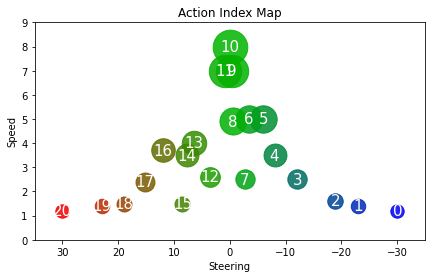

In [42]:
# Plot Index Map to understand graph
plot_index_map(asl)

Every dot is one step. Dot size is proportional to the throttle
Colors: Green = Straight, Red = Steering Left, Blue = Steering Right


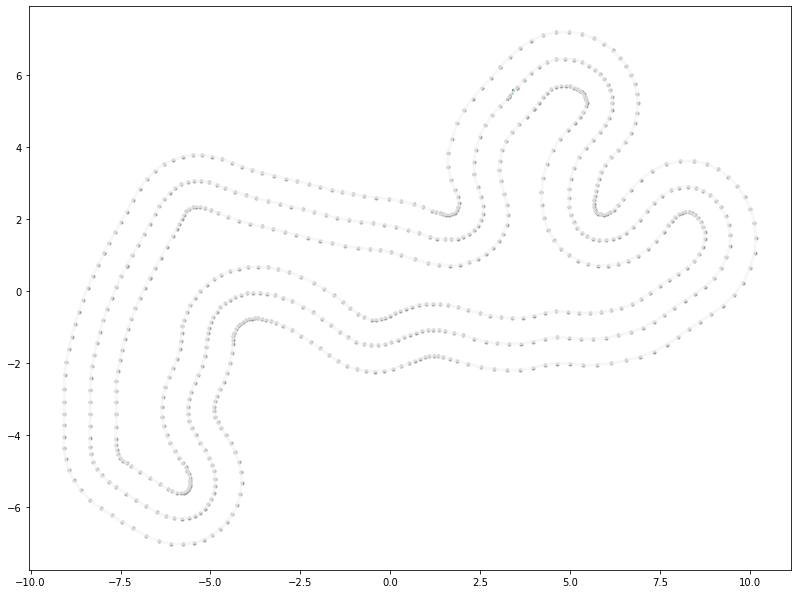

In [43]:
print("Every dot is one step. Dot size is proportional to the throttle")
print("Colors: Green = Straight, Red = Steering Left, Blue = Steering Right")
#EPZ = 31
plot_episode_color(df,EPZ) #, l_inner_border, l_inner_border, l_outer_border) # arbitrary episode

Histograms for episode: 4525


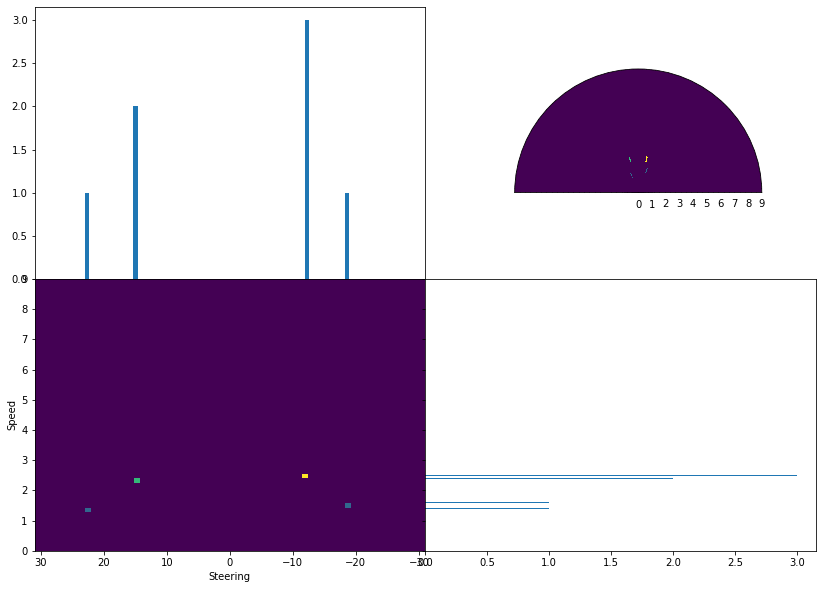

In [44]:
plot_4_hist(df, E = EPZ)

Histograms for episode: 4525


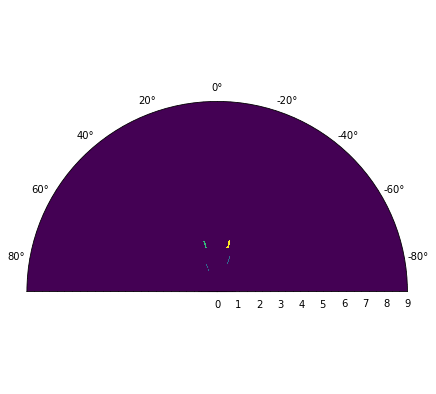

In [45]:
plot_polar_hist(df, E = EPZ)

<AxesSubplot:xlabel='closest_waypoint'>

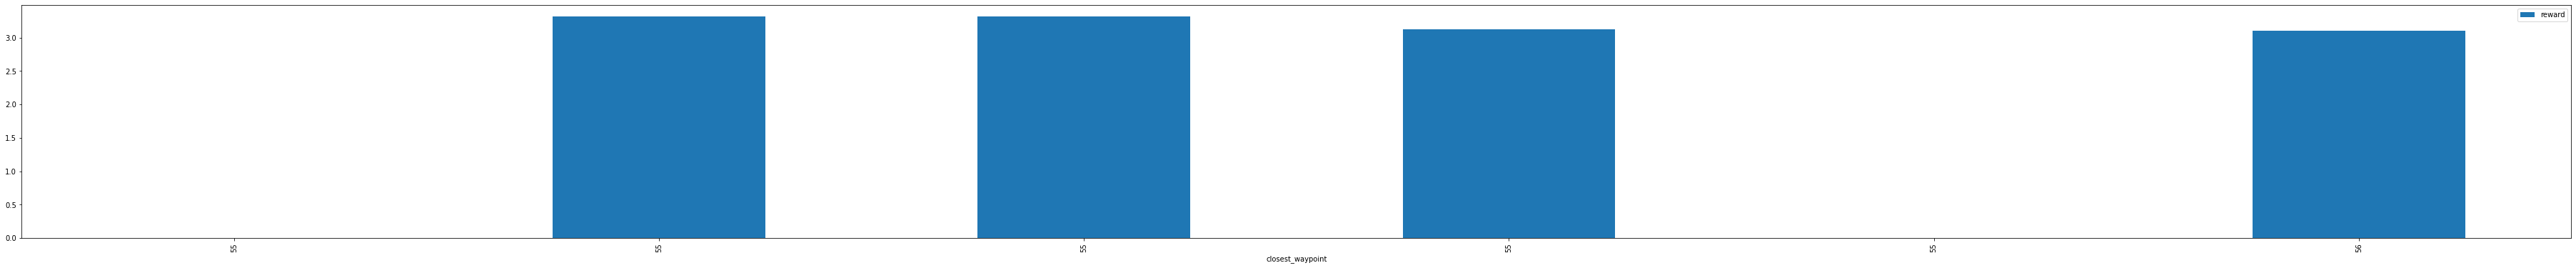

In [46]:
#This shows a histogram of actions per waypoint. Will let you spot potentially problematic places
episode = df[df['episode']==EPZ]
episode[:-1].plot.bar(x='closest_waypoint', y='reward',figsize=(64, 6))

# Analyzing Actions
## You can analyze all actions or only set of actions with indexes defined in setActions



 Heatmap for action with index 0: steering: -30.0, throttle: 1.2


<Figure size 432x288 with 0 Axes>

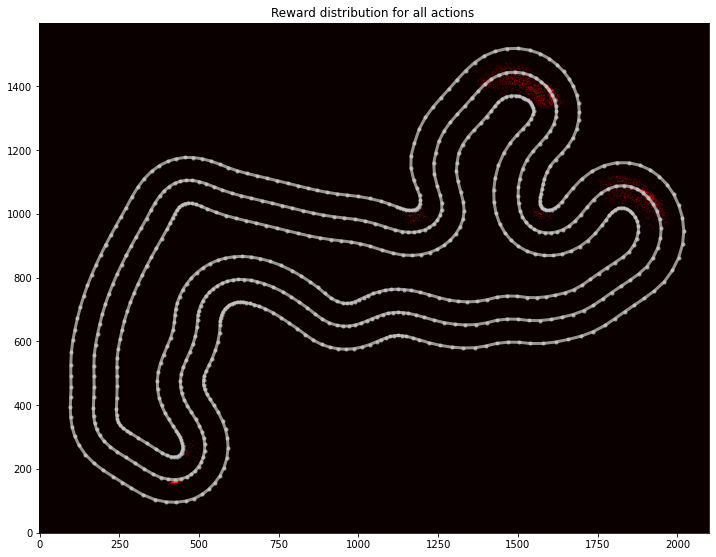

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 1: steering: -23.0, throttle: 1.4


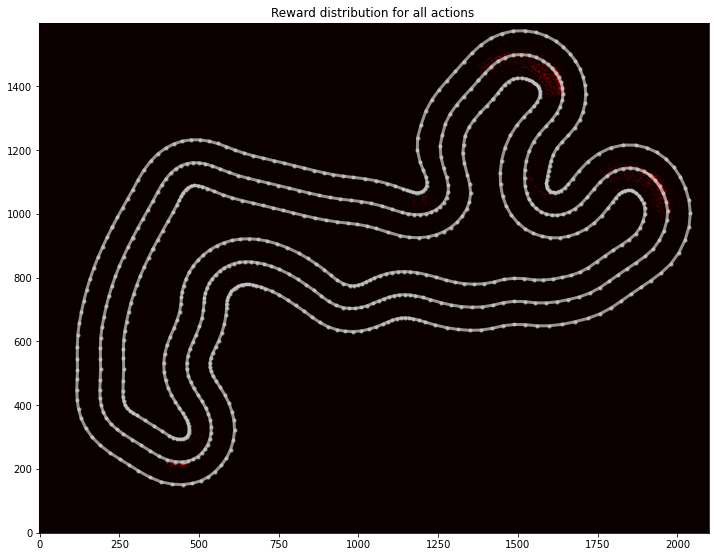

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 2: steering: -18.9, throttle: 1.6


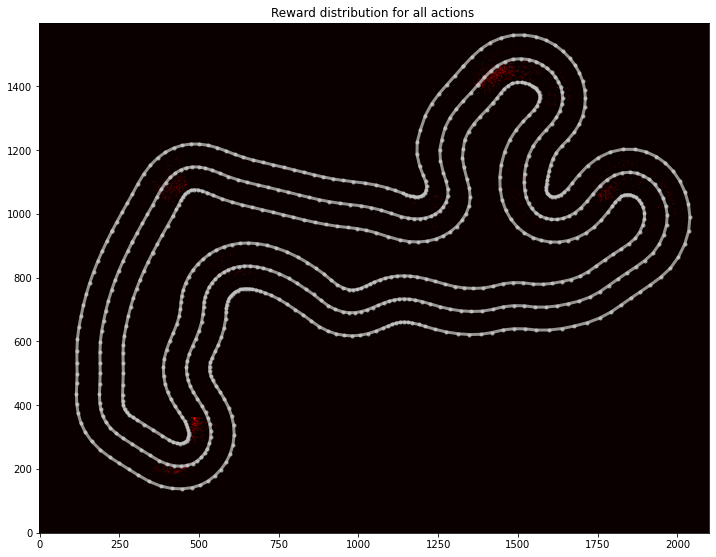

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 3: steering: -12.1, throttle: 2.5


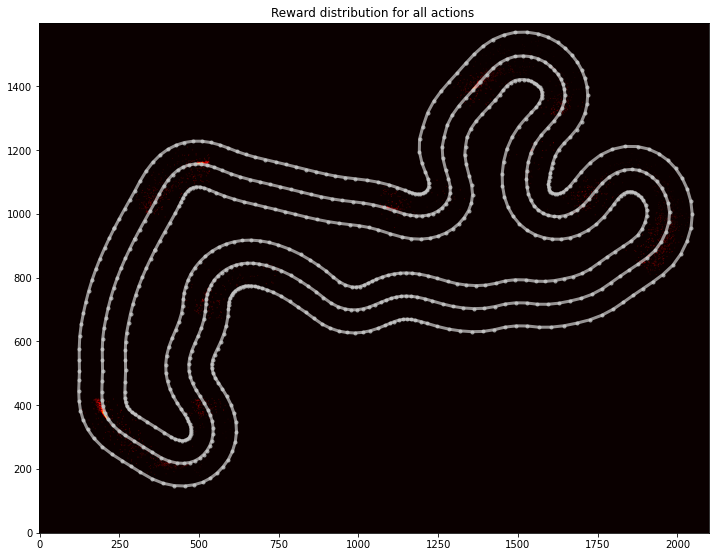

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 4: steering: -8.0, throttle: 3.5


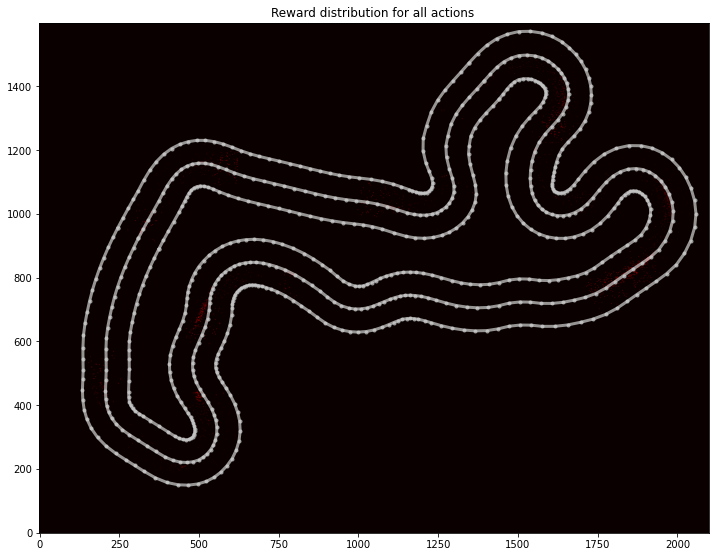

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 5: steering: -6.0, throttle: 5.0


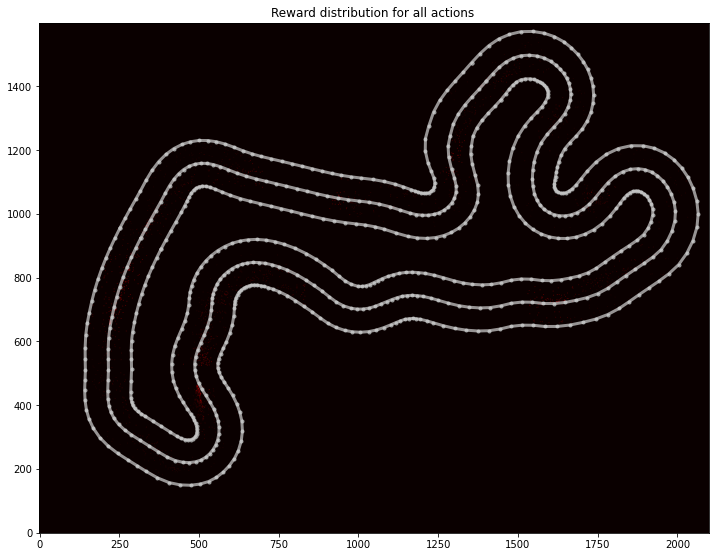

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 6: steering: -3.4, throttle: 5.0


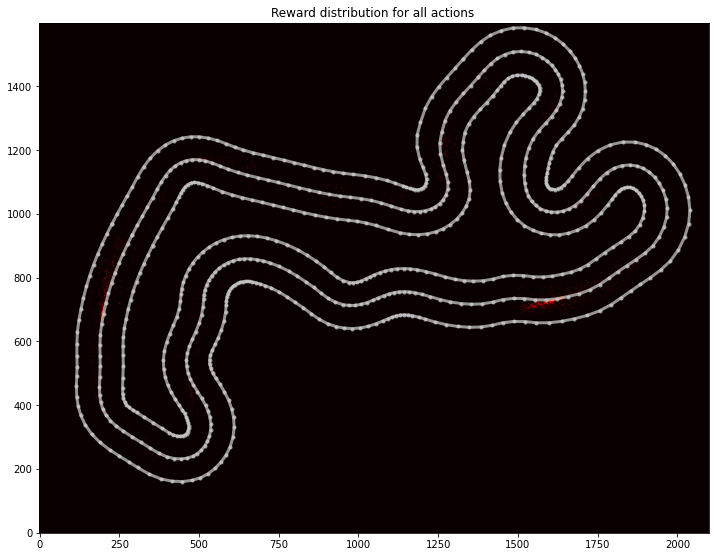

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 7: steering: -2.7, throttle: 2.5


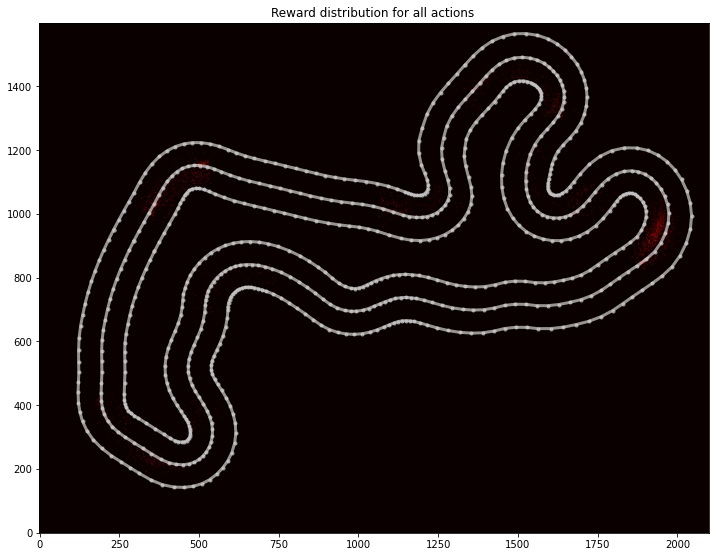

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 8: steering: -0.5, throttle: 4.9


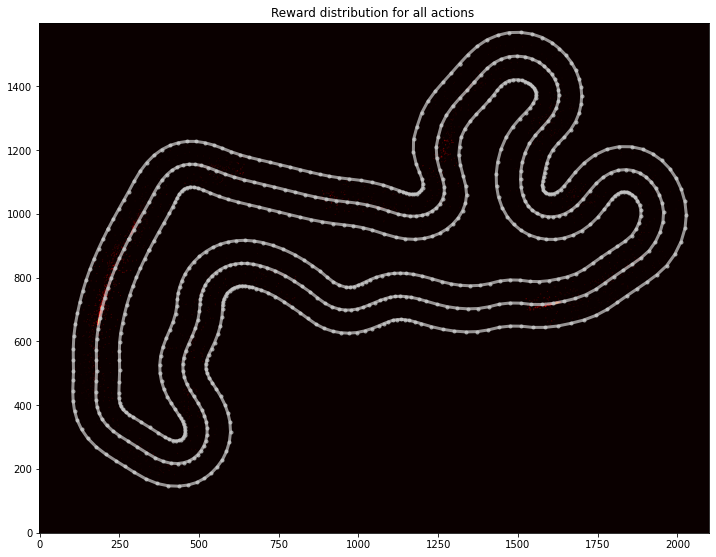

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 9: steering: -0.3, throttle: 7.0


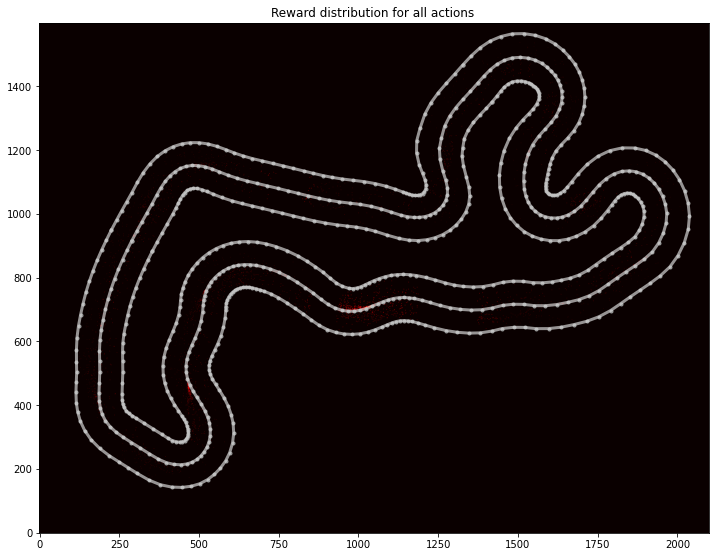

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 10: steering: 0.0, throttle: 8.0


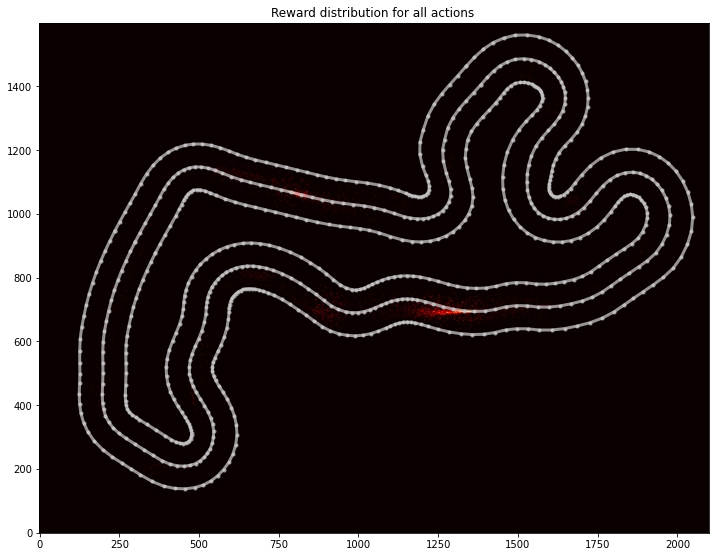

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 11: steering: 0.9, throttle: 7.0


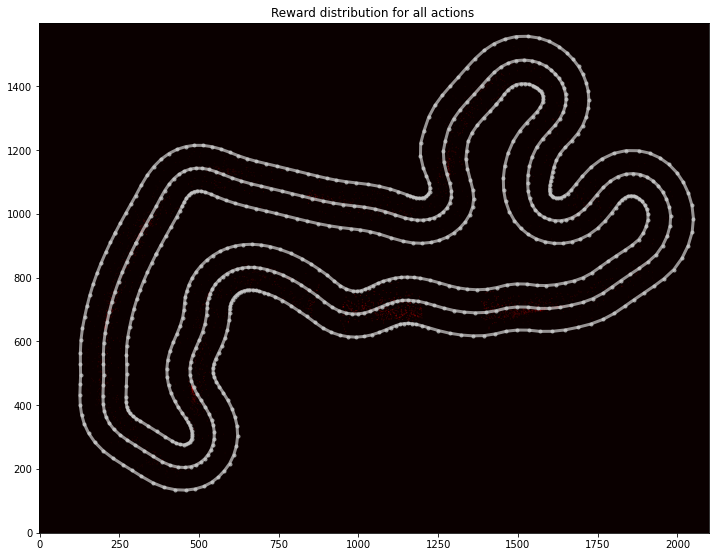

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 12: steering: 3.6, throttle: 2.6


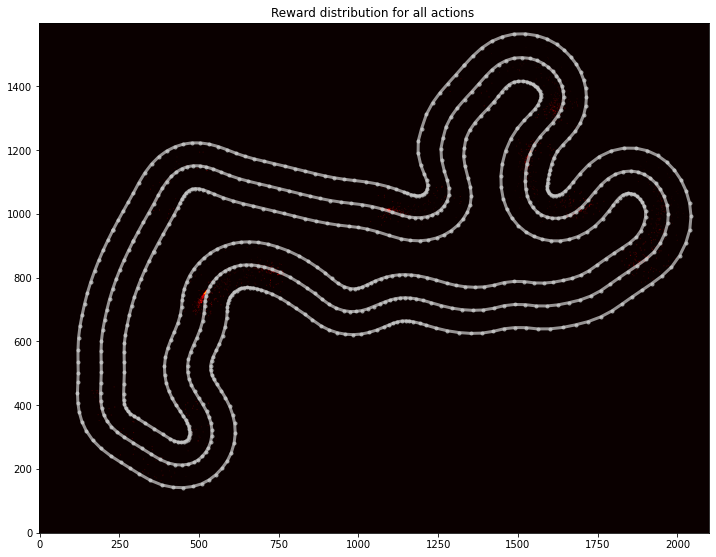

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 13: steering: 6.4, throttle: 4.0


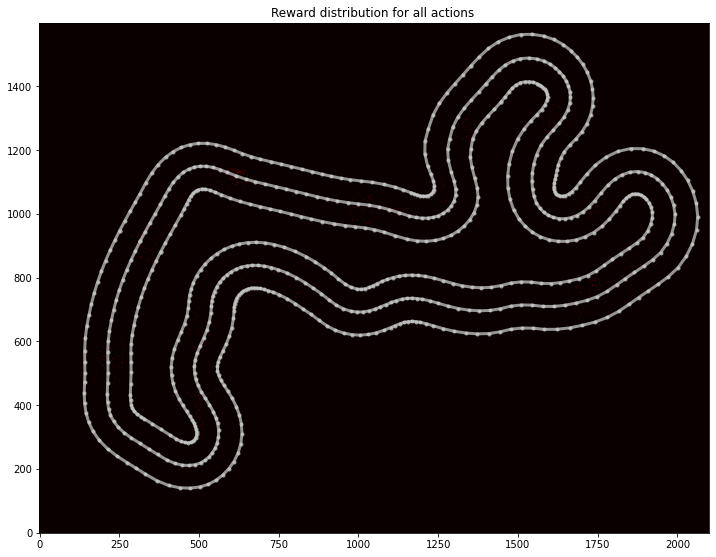

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 14: steering: 7.7, throttle: 3.5


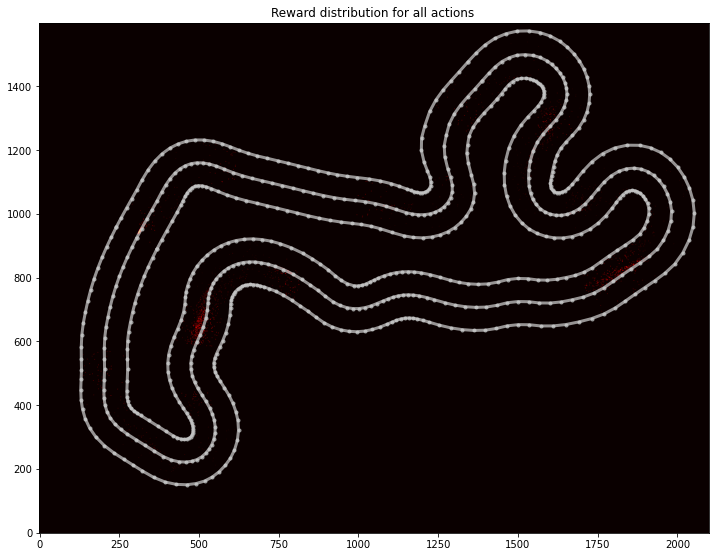

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 15: steering: 8.5, throttle: 1.5


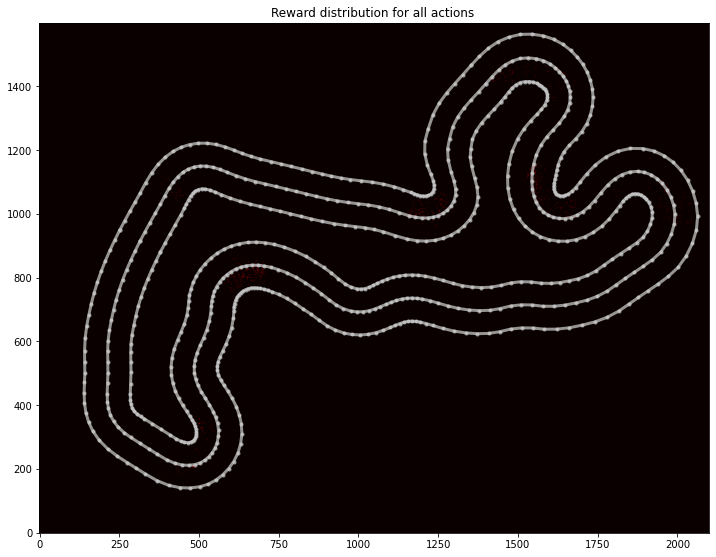

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 16: steering: 12.0, throttle: 3.7


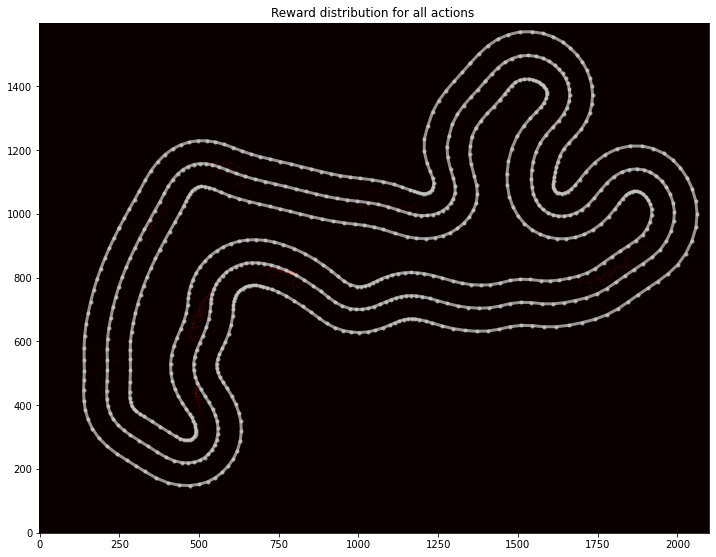

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 17: steering: 15.2, throttle: 2.4


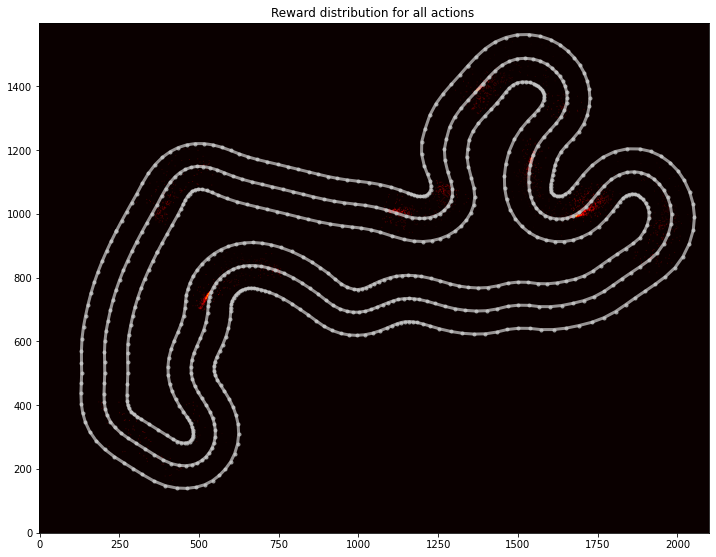

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 18: steering: 19.0, throttle: 1.5


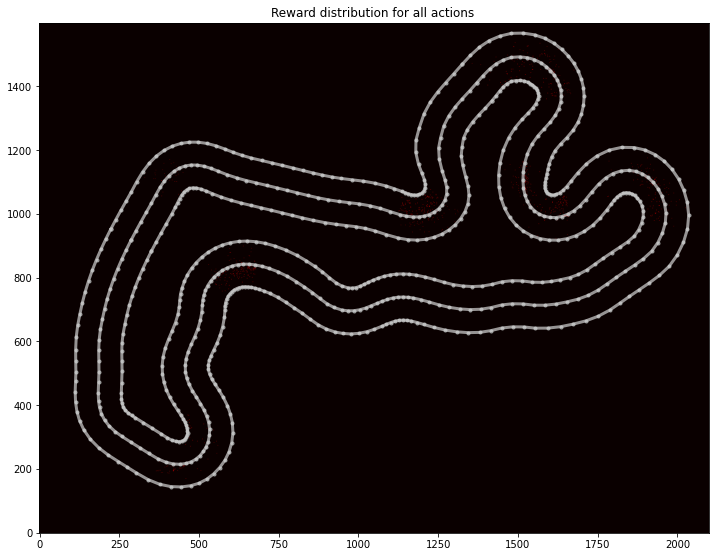

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 19: steering: 23.0, throttle: 1.4


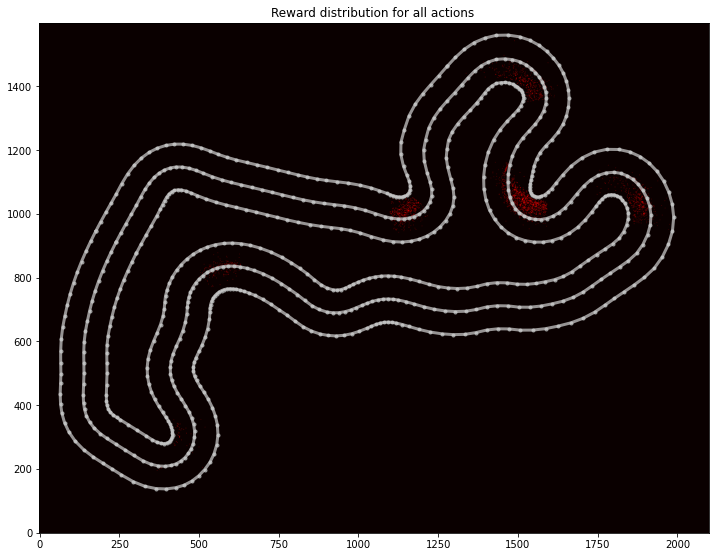

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 20: steering: 30.0, throttle: 1.2


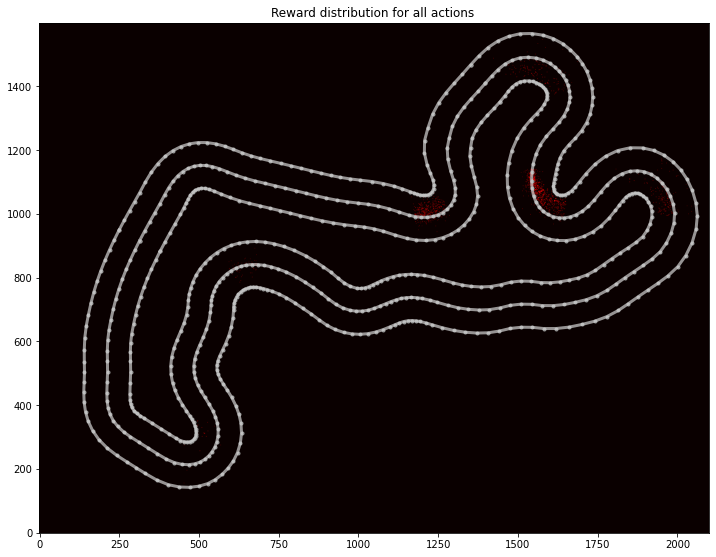

<Figure size 432x288 with 0 Axes>

In [47]:
aslNum = len(asl)
setActions = range(aslNum)     # show graphs for all Actions
#setActions = (0,1,6,8,9)       # show graphs only for index set Actions
fig = plt.figure(aslNum)
for i in setActions: 
    a = asl[i]
    print("\n\n Heatmap for action with index {}: steering: {}, throttle: {}".format(a.index, a.steer,a.throttle))
    tr_plot = pu.plot_track(df[df['action'] == a.index], track, value_field="reward") 
    plt.show()

In [48]:
df[df['on_track']=='False'].count()[""]

KeyError: ''